# Decision Tree

In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random
from pprint import pprint
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Loading CSV Data

In [0]:
def load_csv(data, columns=None, header=None):
  banknote = pd.read_csv(data, header=header)
  if columns != None:
    banknote.columns = columns
  return banknote

## Train Test Split

In [0]:
def train_test_split(X, y=None, split_ratio=0.3, random_state=123, stype="separate"):
  np.random.seed(random_state)
  if stype=="separate":
    split = np.random.rand(X.shape[0]) < split_ratio
    return X[~split], X[split], y[~split], y[split]
  elif stype=="whole":
    split = np.random.rand(X.shape[0]) < split_ratio
    return X[~split], X[split] 

## Purity of Data

In [0]:
def check_purity(data):
    
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False


## Create Leaf

In [0]:
def create_leaf(data, ml_task):
    
    label_column = data[:, -1]
    if ml_task == "regression":
        leaf = np.mean(label_column)
        
    # classfication    
    else:
        unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)
        index = counts_unique_classes.argmax()
        leaf = unique_classes[index]
    
    return leaf

## Judging Potential Splits

In [0]:
def get_potential_splits(data):
    
    potential_splits = {}
    _, n_columns = data.shape
    for column_index in range(n_columns - 1):          # excluding the last column which is the label
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        potential_splits[column_index] = unique_values
    
    return potential_splits

## Split Data

In [0]:
def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value]
    
    # feature is categorical   
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]
    
    return data_below, data_above

## Determine Best Split


In [0]:
def calculate_mse(data):
    actual_values = data[:, -1]
    if len(actual_values) == 0:   # empty data
        mse = 0
        
    else:
        prediction = np.mean(actual_values)
        mse = np.mean((actual_values - prediction) **2)
    
    return mse

In [0]:
def calculate_gini(data):
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    gini = 1 - sum(probabilities**2)
     
    return gini

In [0]:
def calculate_entropy(data):
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy


In [0]:
def calculate_overall_metric(data_below, data_above, metric_function):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_metric =  (p_data_below * metric_function(data_below) 
                     + p_data_above * metric_function(data_above))
    
    return overall_metric

In [0]:
def determine_best_split(data, potential_splits, criterion, ml_task):
    
    first_iteration = True
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            
            if ml_task == "regression":
                current_overall_metric = calculate_overall_metric(data_below, data_above, metric_function=calculate_mse)
            
            # classification
            else:
                if criterion=="entropy":
                  current_overall_metric = calculate_overall_metric(data_below, data_above, metric_function=calculate_entropy)
                elif criterion=="gini":
                  current_overall_metric = calculate_overall_metric(data_below, data_above, metric_function=calculate_gini)

            if first_iteration or current_overall_metric <= best_overall_metric:
                first_iteration = False
                
                best_overall_metric = current_overall_metric
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value


# Decision Tree Algorithm

## Determine Type of Feature


In [0]:
def determine_type_of_feature(df):
    
    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types

In [0]:
def decision_tree_algorithm(df, criterion="entropy", ml_task="classification", counter=0, min_samples=2, max_depth=5):
    
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df           
    
    
    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        leaf = create_leaf(data, ml_task)
        return leaf

    
    # recursive part
    else:    
        counter += 1

        # helper functions 
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits, criterion, ml_task)
        data_below, data_above = split_data(data, split_column, split_value)
        
        # check for empty data
        if len(data_below) == 0 or len(data_above) == 0:
            leaf = create_leaf(data, ml_task)
            return leaf
        
        # determine question
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)
            
        # feature is categorical
        else:
            question = "{} = {}".format(feature_name, split_value)
        
        # instantiate sub-tree
        sub_tree = {question: []}
        
        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, criterion, ml_task, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_above, criterion, ml_task, counter, min_samples, max_depth)
        
        # If the answers are the same, then there is no point in asking the qestion.
        # This could happen when the data is classified even though it is not pure
        # yet (min_samples or max_depth base case).
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

## Classification Task

In [0]:
def classify_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split()

    # ask question
    if example[feature_name] <= float(value):
        answer = tree[question][0]
    else:
        answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return classify_example(example, residual_tree)

In [0]:
def calculate_accuracy(df, tree, label_class="class"):

    df["classification"] = df.apply(classify_example, axis=1, args=(tree,))
    df["classification_correct"] = df["classification"] == df[label_class]
    
    accuracy = df["classification_correct"].mean()
    
    return accuracy

## Regression Task

In [0]:
def predict_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if comparison_operator == "<=":
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    # feature is categorical
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return predict_example(example, residual_tree)

In [0]:
def calculate_r_squared(df, tree):    
    labels = df.label
    mean = labels.mean()
    predictions = df.apply(predict_example, args=(tree,), axis=1)

    ss_res = sum((labels - predictions) ** 2)
    ss_tot = sum((labels - mean) ** 2)
    r_squared = 1 - ss_res / ss_tot
    
    return r_squared

# Running our Decision Tree Classifier vs Sklearn Decision Tree Classifier

In [19]:
columns = ['variance', 'skewness', 'curtosis', 'entropy', 'class']
data = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"
banknote = load_csv(data, columns)
banknote.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [20]:
banknote.shape

(1372, 5)

In [21]:
# Selecting X and y
X = banknote.iloc[:, :-1]
y = banknote.iloc[:,-1]
print(X.head())
print(y.head())

   variance  skewness  curtosis  entropy
0   3.62160    8.6661   -2.8073 -0.44699
1   4.54590    8.1674   -2.4586 -1.46210
2   3.86600   -2.6383    1.9242  0.10645
3   3.45660    9.5228   -4.0112 -3.59440
4   0.32924   -4.4552    4.5718 -0.98880
0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int64


In [22]:
# Train and Test split
X_train, X_test, y_train, y_test = train_test_split(X, y=y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
data_train, data_test = train_test_split(banknote, stype="whole")
print(data_train.shape)
print(data_test.shape)

(952, 4)
(420, 4)
(952,)
(420,)
(952, 5)
(420, 5)


In [23]:
ntree_entropy = decision_tree_algorithm(data_train, criterion="entropy", ml_task="classification", max_depth=3, min_samples=5)
pprint(ntree_entropy)

{'variance <= 0.31803000000000003': [{'skewness <= 5.8333': [1.0,
                                                             {'variance <= -4.1479': [1.0,
                                                                                      0.0]}]},
                                     {'variance <= 1.7331': [{'curtosis <= -2.2726': [1.0,
                                                                                      0.0]},
                                                             {'curtosis <= -4.8037': [1.0,
                                                                                      0.0]}]}]}


In [24]:
accuracy = calculate_accuracy(data_test, ntree_entropy)
accuracy

0.9619047619047619

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

In [26]:
clf_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 100,
                               max_depth=3, min_samples_leaf=5)
clf_entropy.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=100, splitter='best')

In [27]:
y_pred = clf_entropy.predict(X_test)
#print(y_pred)
print ("Accuracy is ", accuracy_score(y_test,y_pred)*100)

Accuracy is  96.19047619047619


## Save Tree as Png

In [0]:
import pydotplus
import collections
## sudo apt-get install graphviz
def visualize_graph(clf,features,name):
    # Visualize data
    dot_data = tree.export_graphviz(clf,
                                    feature_names=features,
                                    out_file=None,
                                    filled=True,
                                    rounded=True)
    graph = pydotplus.graph_from_dot_data(dot_data)
    
    colors = ('turquoise', 'orange')
    edges = collections.defaultdict(list)
    
    for edge in graph.get_edge_list():
        edges[edge.get_source()].append(int(edge.get_destination()))
    
    for edge in edges:
        edges[edge].sort()    
        for i in range(2):
            dest = graph.get_node(str(edges[edge][i]))[0]
            dest.set_fillcolor(colors[i])
    
    graph.write_png(name+".png")

In [0]:
visualize_graph(clf_entropy,banknote.columns[:-1],"dt_en")

**Let's Try the Same With Gini**

## Our Classifier

In [30]:
ntree = decision_tree_algorithm(data_train, criterion="gini", ml_task="classification", max_depth=3, min_samples=5)
pprint(ntree)
accuracy = calculate_accuracy(data_test, ntree)
print(accuracy)

{'variance <= 0.31803000000000003': [{'skewness <= 5.8333': [1.0,
                                                             {'variance <= -4.1479': [1.0,
                                                                                      0.0]}]},
                                     {'curtosis <= -4.3882': [{'skewness <= 5.2022': [1.0,
                                                                                      0.0]},
                                                              0.0]}]}
0.9428571428571428


## Sklearn Classifier

In [31]:
clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=5)
clf_gini.fit(X_train, y_train)

y_pred = clf_gini.predict(X_test)
#print(y_pred)
print ("Accuracy is ", accuracy_score(y_test,y_pred)*100)

Accuracy is  94.28571428571428


In [0]:
visualize_graph(clf_gini,banknote.columns[:-1],"dt_gi")

# Running our Decision Tree Classifier vs Sklearn Decision Tree Classifier

In [33]:
#!wget "https://archive.ics.uci.edu/ml/bike-learning-databases/00275/Bike-Sharing-Dataset.zip"
#!unzip Bike-Sharing-Dataset.zip
data = "hour.csv"
bike = load_csv(data, header=0)
bike.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [34]:
bike = bike.drop(["instant", "casual", "registered"], axis=1)
bike = bike.rename({"dteday": "date"}, axis=1)
bike.head()

,date,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


In [0]:
bike['date'] = pd.to_datetime(bike['date'], errors='coerce')
date_column = bike.date

bike["day_of_year"] = date_column.dt.dayofyear
bike["day_of_month"] = date_column.dt.day

bike["quarter"] = date_column.dt.quarter
bike["week"] = date_column.dt.week

bike["is_month_end"] = date_column.dt.is_month_end
bike["is_month_start"] = date_column.dt.is_month_start
bike["is_quarter_end"] = date_column.dt.is_quarter_end
bike["is_quarter_start"] = date_column.dt.is_quarter_start
bike["is_year_end"] = date_column.dt.is_year_end
bike["is_year_start"] = date_column.dt.is_year_start

bike = bike.set_index("date")

In [0]:
bike["label"] = bike.cnt
bike = bike.drop("cnt", axis=1)

In [37]:
bike.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,day_of_year,day_of_month,quarter,week,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start,label
date,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,1,1,1,52,False,True,False,True,False,True,16
2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,1,1,1,52,False,True,False,True,False,True,40
2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,1,1,1,52,False,True,False,True,False,True,32
2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,1,1,1,52,False,True,False,True,False,True,13
2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1,1,1,52,False,True,False,True,False,True,1


In [0]:
train_bike = bike.iloc[:-122]
val_bike = bike.iloc[-122:-61]  # Sep and Oct of 2012
test_bike = bike.iloc[-61:]     # Nov and Dec of 2012

In [39]:
grid_search = {"max_depth": [], "min_samples": [], "r_squared_train": [], "r_squared_val": []}
for max_depth in range(1, 7):
    for min_samples in range(5, 20, 5):
        tree = decision_tree_algorithm(train_bike, ml_task="regression", max_depth=max_depth, min_samples=min_samples)
        
        r_squared_train = calculate_r_squared(train_bike, tree)
        r_squared_val = calculate_r_squared(val_bike, tree)
        
        grid_search["max_depth"].append(max_depth)
        grid_search["min_samples"].append(min_samples)
        grid_search["r_squared_train"].append(r_squared_train)
        grid_search["r_squared_val"].append(r_squared_val)
        
    print(f"Progress: Iteration {max_depth}/6")
        
grid_search = pd.DataFrame(grid_search)
grid_search.sort_values("r_squared_val", ascending=False).head()

Progress: Iteration 1/6
Progress: Iteration 2/6
Progress: Iteration 3/6
Progress: Iteration 4/6
Progress: Iteration 5/6
Progress: Iteration 6/6


,max_depth,min_samples,r_squared_train,r_squared_val
17,6,15,0.693292,0.481885
16,6,10,0.693292,0.481885
15,6,5,0.693292,0.481885
14,5,15,0.648448,0.314057
13,5,10,0.648448,0.314057


In [40]:
best_max_depth = 6
best_min_samples = 15

tree = decision_tree_algorithm(train_bike, ml_task="regression", max_depth=best_max_depth, min_samples=best_min_samples)
calculate_r_squared(test_bike, tree)

0.16353815649125036

In [0]:
def create_plot(df, tree, title):    
    predictions = df.apply(predict_example, args=(tree,), axis=1)
    actual = df.label
    plot_df = pd.DataFrame({"actual": actual, "predictions": predictions})
    
    plot_df.plot(figsize=(18, 5), title=title)
    
    return

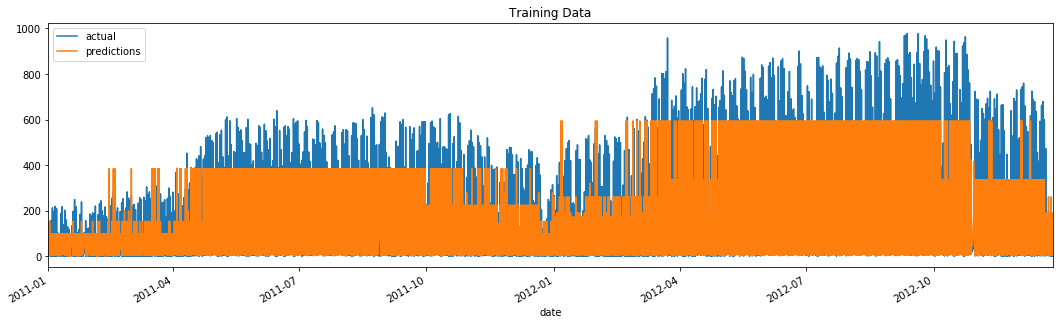

In [42]:
create_plot(train_bike, tree, title="Training Data")

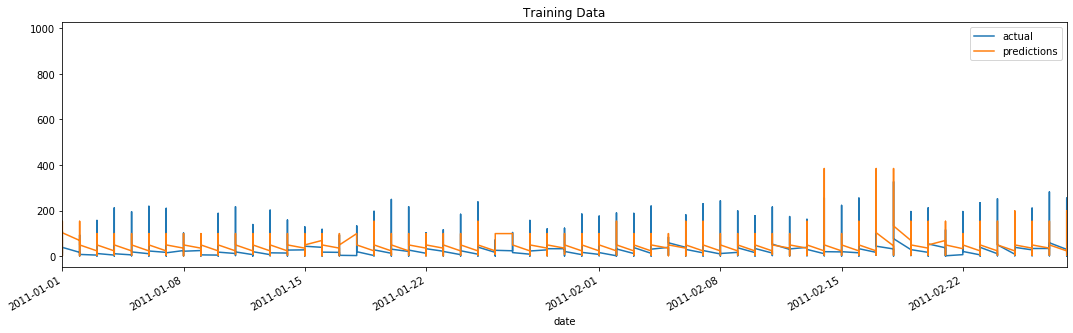

In [43]:
create_plot(train_bike, tree, title="Training Data")
plt.xlim(pd.to_datetime("2011-01-01"), pd.to_datetime("2011-02-28"));

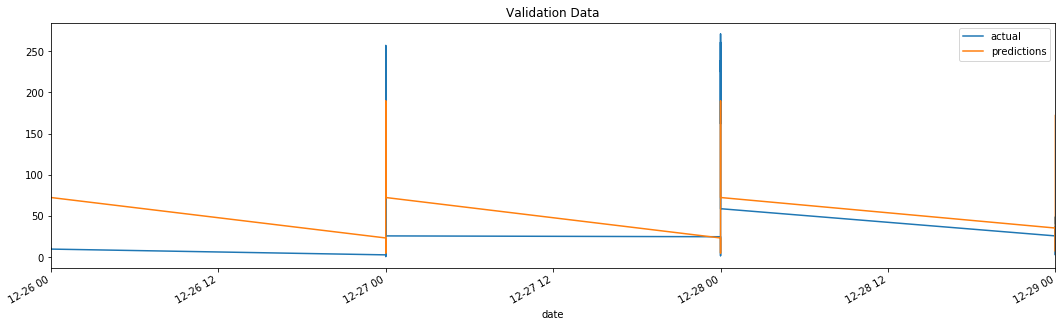

In [44]:
create_plot(val_bike, tree, title="Validation Data")

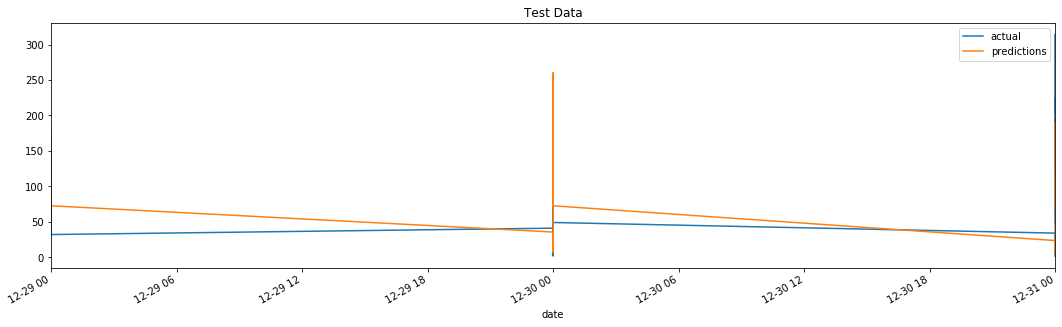

In [45]:
create_plot(test_bike, tree, title="Test Data")

In [58]:
from sklearn.tree import DecisionTreeRegressor

regr_1 = DecisionTreeRegressor(max_depth=6, min_samples_leaf=15)
regr_1.fit(train_bike.iloc[:,:-1], train_bike["label"])

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=6,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=15, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [0]:
def sk_create_plot(df, reg, title):    
    predictions = reg.predict(df.iloc[:,:-1])
    actual = df.label
    plot_df = pd.DataFrame({"actual": actual, "predictions": predictions})
    
    plot_df.plot(figsize=(18, 5), title=title)
    
    return

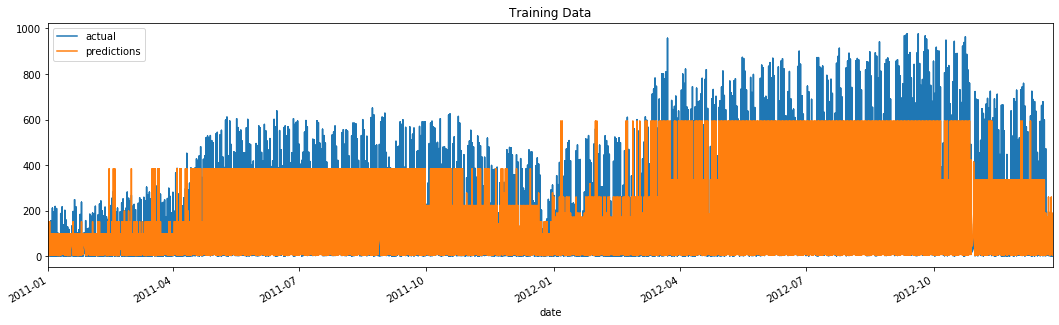

In [62]:
sk_create_plot(train_bike, regr_1, title="Training Data")

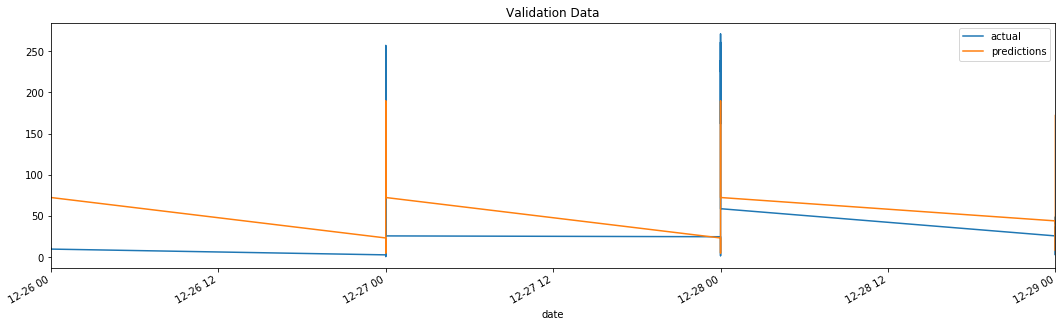

In [63]:
sk_create_plot(val_bike, regr_1, title="Validation Data")

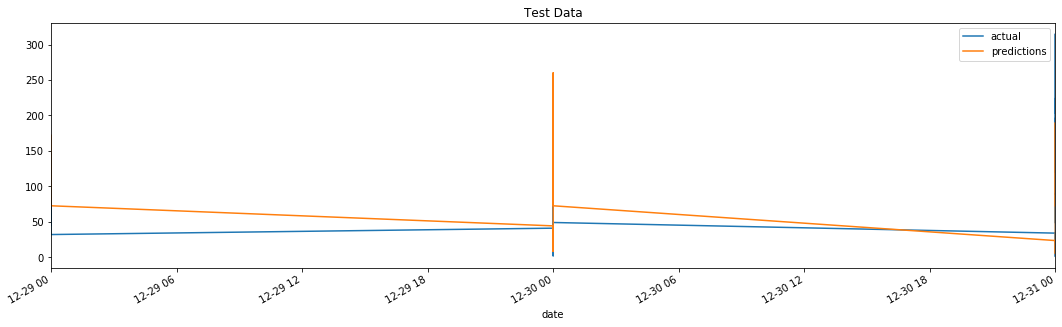

In [64]:
sk_create_plot(test_bike, regr_1, title="Test Data")